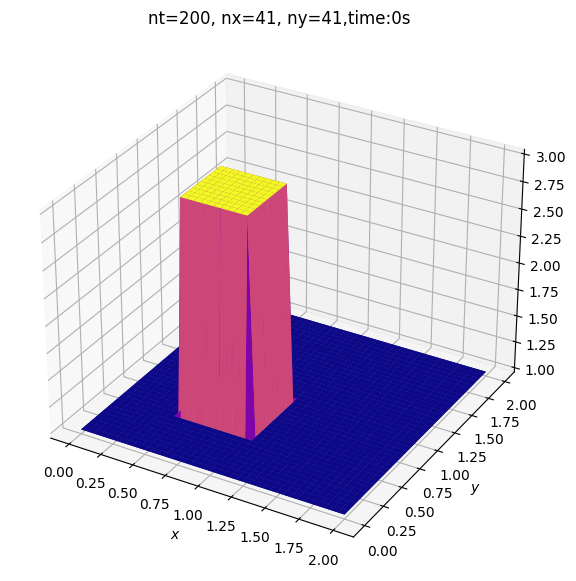

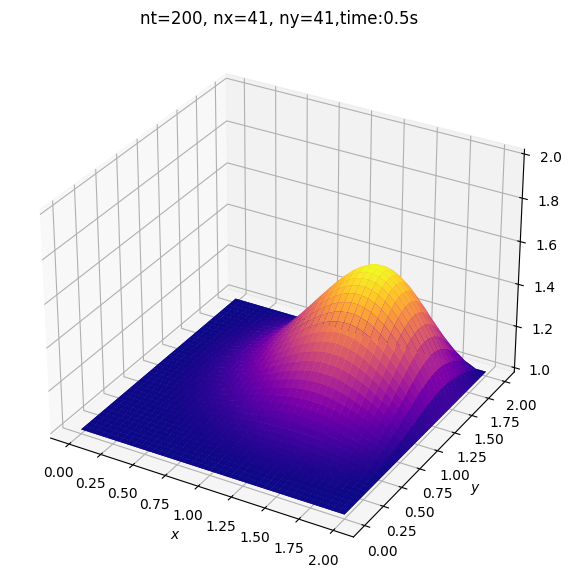

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

#创建变量
nx = 41
ny = 41
nt = 200
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma =0.1
nu = 0.1
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) 
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))
comb = np.ones((ny, nx))
data=np.zeros((nt+1,2,ny,nx))
#初始条件

u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2

v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 3

fig1,ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize = (11,7),dpi = 100)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[:], cmap = cm.plasma, rstride=1, cstride=1)
ax.plot_surface(X, Y, v[:], cmap = cm.plasma, rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.title(f'nt=200, nx=41, ny=41,time:0s')
plt.show()

fig2,ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize = (11,7),dpi = 100)
X, Y = np.meshgrid(x, y)
#迭代计算
for n in range(nt + 1):

    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] *
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] *
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) +
                     nu * dt / dx ** 2 *
                     (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     nu * dt / dy ** 2 *
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) +
                     nu * dt / dx ** 2 *
                     (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy ** 2 *
                     (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))

    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1

    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    data[n,0]=u
    data[n,1]=v
ax.plot_surface(X, Y, data[200,0], cmap= cm.plasma, rstride=1, cstride=1)
ax.plot_surface(X, Y, data[200,1], cmap= cm.plasma, rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.title(f'nt=200, nx=41, ny=41,time:{round(n*dt,3)}s')
ax.set_zlim([1, 2])
plt.pause(0.001)
plt.show()

In [14]:
print(data.shape)
import scipy.io as io
io.savemat('data_burgers.mat',{'u':data})

(201, 2, 41, 41)


In [3]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd1
import numpy as np
from tqdm import tqdm
from models.model import Informer
pre_len = 100
batch_size = 1
device = "cuda"
lr = 5e-5
epochs = 200
data=data.reshape(201,41*41*2)
xx0=data[0:100]
xx1=data[0:200]

In [4]:
lapl_op = [[[[    0,   0, -1/12,   0,     0],
             [    0,   0,   4/3,   0,     0],
             [-1/12, 4/3,    -5, 4/3, -1/12],
             [    0,   0,   4/3,   0,     0],
             [    0,   0, -1/12,   0,     0]]]]

partial_y = [[[[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1/12, -8/12, 0, 8/12, -1/12],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]]]

partial_x = [[[[0, 0, 1/12, 0, 0],
               [0, 0, -8/12, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 8/12, 0, 0],
               [0, 0, -1/12, 0, 0]]]]
class Conv2dDerivative(nn.Module):
    def __init__(self, DerFilter, resol, kernel_size=3, name=''):
        super(Conv2dDerivative, self).__init__()

        self.resol = resol  # constant in the finite difference
        self.name = name
        self.input_channels = 1
        self.output_channels = 1
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)
        self.filter = nn.Conv2d(self.input_channels, self.output_channels, self.kernel_size, 
            1, padding=0, bias=False)

        # Fixed gradient operator
        self.filter.weight = nn.Parameter(torch.FloatTensor(DerFilter), requires_grad=False)  

    def forward(self, input):
        derivative = self.filter(input)
        return derivative / self.resol


class Conv1dDerivative(nn.Module):
    def __init__(self, DerFilter, resol, kernel_size=3, name=''):
        super(Conv1dDerivative, self).__init__()

        self.resol = resol  # $\delta$*constant in the finite difference
        self.name = name
        self.input_channels = 1
        self.output_channels = 1
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)
        self.filter = nn.Conv1d(self.input_channels, self.output_channels, self.kernel_size, 
            1, padding=0, bias=False)
        
        # Fixed gradient operator
        self.filter.weight = nn.Parameter(torch.FloatTensor(DerFilter), requires_grad=False)  

    def forward(self, input):
        derivative = self.filter(input)
        return derivative / self.resol
class loss_generator(nn.Module):
    ''' Loss generator for physics loss '''

    def __init__(self, dt = (1/400), dx = (1/20)):
        ''' Construct the derivatives, X = Width, Y = Height '''
       
        super(loss_generator, self).__init__()

        # spatial derivative operator
        self.laplace = Conv2dDerivative(
            DerFilter = lapl_op,
            resol = (dx**2),
            kernel_size = 5,
            name = 'laplace_operator').cuda()

        self.dx = Conv2dDerivative(
            DerFilter = partial_x,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dx_operator').cuda()

        self.dy = Conv2dDerivative(
            DerFilter = partial_y,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dy_operator').cuda()

        # temporal derivative operator
        self.dt = Conv1dDerivative(
            DerFilter = [[[-1, 0, 1]]],
            resol = (dt*2),
            kernel_size = 3,
            name = 'partial_t').cuda()

    def get_phy_Loss(self, output):

        # spatial derivatives
        laplace_u = self.laplace(output[1:-1, 0:1, :, :])  # [t,c,h,w]
        laplace_v = self.laplace(output[1:-1, 1:2, :, :])

        u_x = self.dx(output[1:-1, 0:1, :, :])
        u_y = self.dy(output[1:-1, 0:1, :, :])
        v_x = self.dx(output[1:-1, 1:2, :, :])
        v_y = self.dy(output[1:-1, 1:2, :, :])

        # temporal derivative - u
        u = output[:, 0:1, 2:-2, 2:-2]
        lent = u.shape[0]
        lenx = u.shape[3]
        leny = u.shape[2]
        u_conv1d = u.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        u_conv1d = u_conv1d.reshape(lenx*leny,1,lent)
        u_t = self.dt(u_conv1d)  # lent-2 due to no-padding
        u_t = u_t.reshape(leny, lenx, 1, lent-2)
        u_t = u_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        # temporal derivative - v
        v = output[:, 1:2, 2:-2, 2:-2]
        v_conv1d = v.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        v_conv1d = v_conv1d.reshape(lenx*leny,1,lent)
        v_t = self.dt(v_conv1d)  # lent-2 due to no-padding
        v_t = v_t.reshape(leny, lenx, 1, lent-2)
        v_t = v_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        u = output[1:-1, 0:1, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]
        v = output[1:-1, 1:2, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]

        assert laplace_u.shape == u_t.shape
        assert u_t.shape == v_t.shape
        assert laplace_u.shape == u.shape
        assert laplace_v.shape == v.shape

        R = 10.0

        # 2D burgers eqn
        f_u = u_t + u * u_x + v * u_y - (1/R) * laplace_u
        f_v = v_t + u * v_x + v * v_y - (1/R) * laplace_v

        return f_u, f_v


def compute_loss(output, loss_func):
    ''' calculate the phycis loss '''
    
    # Padding x axis due to periodic boundary condition
    # shape: [t, c, h, w]
    output = torch.cat((output[:, :, :, -2:], output, output[:, :, :, 0:3]), dim=3)

    # Padding y axis due to periodic boundary condition
    # shape: [t, c, h, w]
    output = torch.cat((output[:, :, -2:, :], output, output[:, :, 0:3, :]), dim=2)

    # get physics loss
    mse_loss = nn.MSELoss()
    f_u, f_v = loss_func.get_phy_Loss(output)
    loss =  mse_loss(f_u, torch.zeros_like(f_u).cuda()) + mse_loss(f_v, torch.zeros_like(f_v).cuda()) 

    return loss


In [5]:
class AmaData(Dataset):
    def __init__(self, values, labels):

        self.values, self.labels = values, labels
    def __len__(self):
         return len(self.values)
    
    def __getitem__(self, item):
        
        data1=self.values
        time = data1[:, 0:100]
        len_t=len(time[0])
        time_data1 =np.int32(list(range(0, len_t)))[:, None]
        data1=np.float32(data1)
        data2=self.labels
        time = data2[:, 0:200]
        len_t=len(time[0])
        time_data2 =np.int32(list(range(0, len_t)))[:, None]
        data2=np.float32(data2)
        
        return data1,data2,time_data1,time_data2
def train():
   
    train_data = AmaData(xx0,xx1)
    train_data = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    model = Informer()
    model.train()
    model.to(device)

    loss_fc = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        pbar = tqdm(train_data)
        for step, (x, y ,xt, yt) in enumerate(pbar):
            mask = torch.zeros_like(y)[:, pre_len:].to(device)
            
            x, y, xt, yt = x.to(device), y.to(device), xt.to(device), yt.to(device)
            dec_y = torch.cat([y[:, :pre_len], mask], dim=1)
            
            logits = model(x, xt, dec_y, yt)
            z=y[:, :pre_len]
            
            #             z=z.reshape(80,2,51,51)
            logits=abs(logits)+1
            data= z.reshape(100,2,41,41)
            data1=logits.reshape(100,2,41,41)
            
            loss_func = loss_generator(dt=1/400, dx=1/20)
            data2=torch.cat([data,data1],dim=0)
            data2[:,:,0, :] = 1  # 第一行
            data2[:,:,-1, :] = 1 # 最后一行
            data2[:,:,:, 0] = 1   # 第一列
            data2[:,:,:, -1] = 1 # 最后一列
            loss = compute_loss(data2, loss_func)
          
            # loss = loss_fc(logits, y[:, pre_len:])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            s = "train ==> epoch:{} - step:{} - loss:{}".format(epoch, step, loss)

            pbar.set_description(s)

        model.eval()
    # print(data[10,1,20:40,20:40])
    print(loss_fc(logits, y[:, pre_len:]))
    # data=logits.reshape(80,51,51,2)
    # print(data[10,10,10,1])
    return data2
    # print(y[])
    # torch.save(logits)
        # with torch.no_grad():

        #     pbar = tqdm(test_data)
        #     for step, (x, y, xt, yt) in enumerate(pbar):
        #         mask = torch.zeros_like(y)[:, pre_len:].to(device)

        #         x, y, xt, yt = x.to(device), y.to(device), xt.to(device), yt.to(device)
        #         dec_y = torch.cat([y[:, :pre_len], mask], dim=1)

        #         logits = model(x, xt, dec_y, yt)

        #         loss = loss_fc(logits, y[:, pre_len:])

        #         s = "test ==> epoch:{} - step:{} - loss:{}".format(epoch, step, loss)

        #         pbar.set_description(s)

        # model.train()

if __name__ == '__main__':
    data=train()


train ==> epoch:0 - step:99 - loss:61.41954040527344: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s]
train ==> epoch:1 - step:99 - loss:28.737092971801758: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]
train ==> epoch:2 - step:99 - loss:15.443958282470703: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]
train ==> epoch:3 - step:99 - loss:10.54574966430664: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]
train ==> epoch:4 - step:99 - loss:9.374202728271484: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]
train ==> epoch:5 - step:99 - loss:7.8908491134643555: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]
train ==> epoch:6 - step:99 - loss:6.6078386306762695: 100%|██████████| 100/100 [00:10<00:00,  9.33it/s]
train ==> epoch:7 - step:99 - loss:6.080836772918701: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]
train ==> epoch:8 - step:99 - loss:6.034558296203613: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]
train ==> epoch:9 - step:99 - loss:5.356955051422119: 100%|█

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


In [10]:
uu=data[:, :, :,:]

# torch.save(data,'data 2d burgers')
print(uu.shape)
# torch.save(uu,'data')
uu=uu.reshape(200,2,41,41)
# uu=uu.permute(1,2,0)
uu=uu.cpu().detach().numpy()
import scipy.io as io
io.savemat('data_pred_burgers.mat',{'u':uu})
print(uu.shape)

torch.Size([200, 2, 41, 41])
(200, 2, 41, 41)


In [16]:
u=data[0:200]-uu

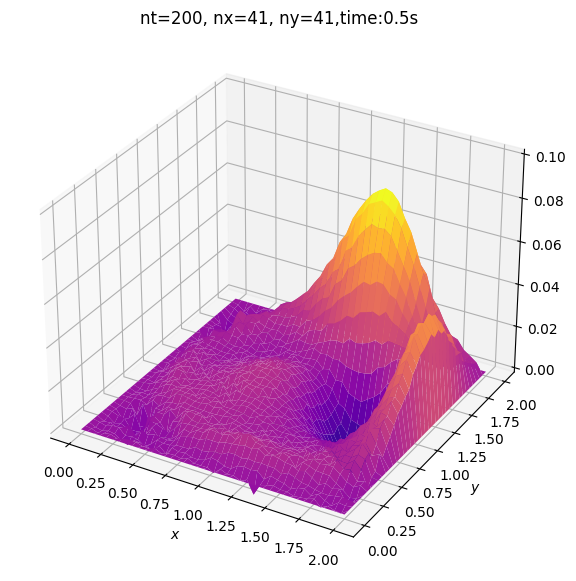

In [34]:
fig2,ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize = (11,7),dpi = 100)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[175,1], cmap= cm.plasma, rstride=1, cstride=1)
# ax.plot_surface(X, Y, v, cmap= cm.plasma, rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.title(f'nt=200, nx=41, ny=41,time:{round(n*dt,3)}s')
ax.set_zlim([0, 0.1])
plt.pause(0.001)
plt.show()